## **Assignment 2 - Spark-Cassandra-Kafka**

This document represents the report of the second assignment for the Large-Scale Data Management course.

### **Part 1 - kafka_producer**

This script simulates a real-time stream of movie reviews and publishes them to a Kafka topic.

The script performs the following steps:

- Imports libraries and initializes resources:

    - Loads modules for asynchronous Kafka communication, fake data generation (`Faker`), and time handling.

    - Reads a list of movie titles from `movies.csv`.

    - Generates a list of fake reviewers, including my own name.

- Defines a JSON serializer:

    - Converts dictionaries into JSON-formatted strings, suitable for Kafka message transmission.

- Implements asynchronous Kafka producer (`produce` function):

    - Initializes an `AIOKafkaProducer` with gzip compression and JSON serialization.

    - Sends movie review messages to the Kafka topic `movie_reviews` in an infinite loop.

- Generates streaming data:

    - For each reviewer, constructs a review entry containing:

        - Reviewer name

        - Movie title

        - Current timestamp

        - Random rating (1 to 10)

    - Waits 5 seconds between each review to simulate a real-time stream.

- Starts the Kafka stream:

    - Uses `asyncio` event loop to run the `produce` function continuously.

### **Part 2 - stream_process_cassandra**

This script performs real-time processing of movie review data streamed from Kafka and stores enriched results into a Cassandra database.

The script performs the following steps:

- Imports libraries and initializes Spark session:

    - Sets up `SparkSession` with Kafka and Cassandra support.

    - Defines default processing interval (30 seconds, customizable via command-line argument).

- Defines schema:

    - Specifies a schema for parsing incoming Kafka messages containing movie review data.

- Loads static movie information:

    - Reads `netflix.csv` containing movie metadata (e.g., director, country, maturity rating).

- Reads Kafka stream:

    - Consumes streaming data from the Kafka topic `movie_reviews`.

    - Parses each message according to the defined schema.

- Processes review timestamps:

    - Converts `time` field to a proper timestamp.

    - Extracts and formats the review hour (`hour`) as a string in the format `"yyyy-MM-dd HH:00"`.

- Enriches review data:

    - Joins incoming reviews with static movie information on the `movie` title.

- Prepares final output schema:

    - Reorders the relevant columns for the final output.

- Writes to Cassandra:

    - Defines a `write_to_cassandra` function to append each batch to the `movie_reviews` table in the `movies` keyspace.

- Starts the stream:

    - Begins the structured streaming query using `foreachBatch`, triggering at the defined interval.

### **Cassandra Data Model - `movie_reviews` Table**

The `movie_reviews` table is designed specifically to support efficient aggregations for a particular reviewer and hour, as required by the assignment.

The schema is:

`PRIMARY KEY ((reviewer, hour), time, movie)`

This design was chosen for the following reasons:

- Partition Key (`reviewer, hour`):

    - Groups all reviews submitted by a specific person during a specific hour into the same partition.

    - Enables highly efficient queries to retrieve all movies reviewed by a given user in a given hour — which is exactly the type of query needed to calculate metrics such as average rating, average duration, or list of movie titles.

    - Helps avoid full table scans and supports fast, targeted access patterns.

- Clustering key (`time, movie`):

    - Organize the data within each partition chronologically, enabling time-based filtering and ordering.

    - Including movie as a clustering column key ensures uniqueness in case the same reviewer rates multiple movies at the same time.

- Additional Columns (e.g., rating, duration, director, etc.):

    - Provide context for aggregation (e.g., computing the average duration of movies reviewed).

### **Sample of the `movie_reviews` table**

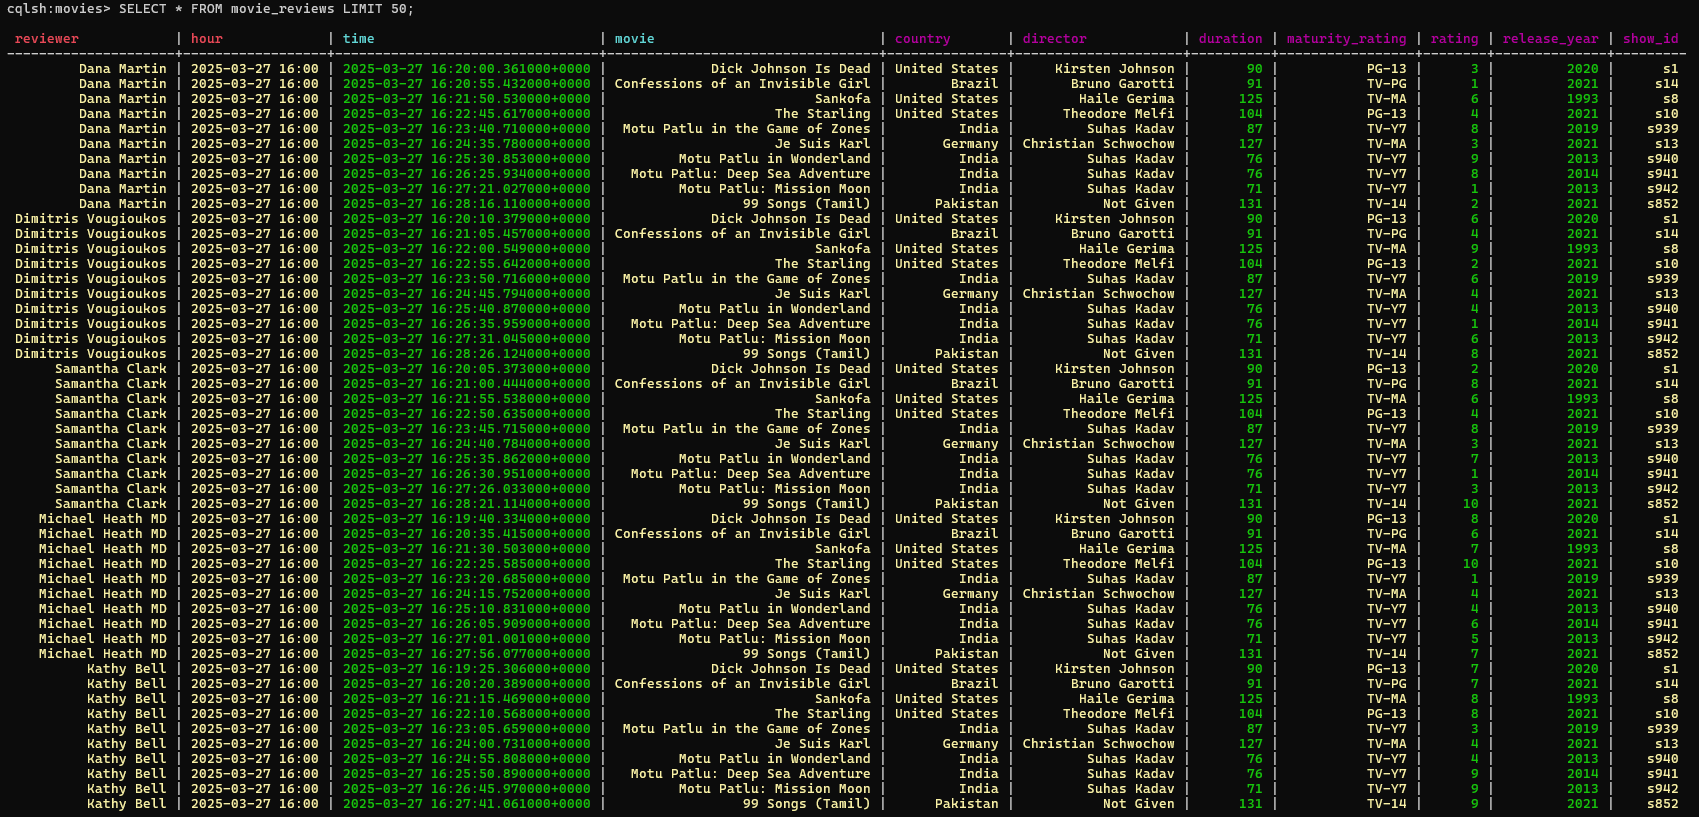

### **CQL Queries**

**• Movies rated by 'Dimitris Vougioukos' during '2025-03-27 16:00'**

`SELECT movie FROM movie_reviews WHERE reviewer = 'Dimitris Vougioukos' and hour = '2025-03-27 16:00';`

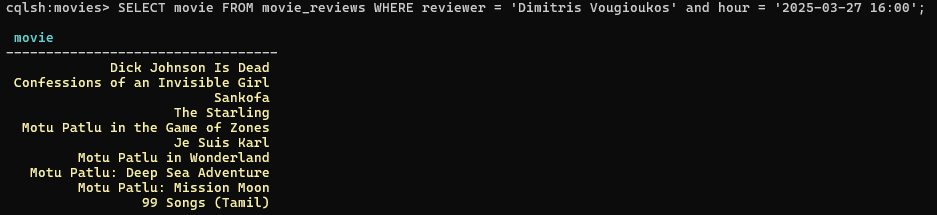

**• Average runtime/duration of the movies rated by 'Dimitris Vougioukos' during '2025-03-27 16:00'**

`SELECT AVG(duration) AS average_runtime FROM movie_reviews WHERE reviewer = 'Dimitris Vougioukos' and hour = '2025-03-27 16:00';`

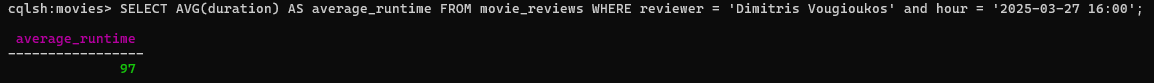